In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import io
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Embedding
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.metrics import Accuracy, F1Score
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("cleaned_req_dataset.csv")


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479938 entries, 0 to 479937
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    479938 non-null  object
 1   label   479938 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.3+ MB


In [4]:
df.head()

,text,label
0,id feel a bit calmer a bit more reassured etc,2
1,Do you have any stomachache ?,3
2,i wound up feeling mad that i didnt watch a hr...,0
3,i shouldnt be too surprised or impatient but i...,0
4,Yes . My only recreation is skateboarding .,3


### Data Cleaning
1. Removing white space
2. Removing not numbers or letter characters
4. Lowercasing
5. Removeing stop words
6. Removing URLs
7. Removign Number
8. Removing specical character

In [5]:
def text_cleaning(text, stopwords):
    # removing space
    text = text.str.replace(r'\s+', ' ', regex = True)
    # removing non number and letter characters
    text = text.apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))
    # lowercasing
    text = text.str.lower()
    # removing stop words
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
    # removing number
    text = text.str.replace(r'\d+', '', regex = True)
    # removing url
    text = text.str.replace(r'http\S+', '', regex = True)
    # removing special character
    text = text.str.replace(r'[^\w\s]', '', regex = True)
    # removing url
    text = text.str.replace(r'http\S+', '', regex = True)

    return text

In [6]:
stopwords_list = stopwords.words('english')
df['text'] = text_cleaning(df['text'], stopwords_list)

### Split Train Test Set

In [7]:
X = df['text']
y = df['label']

# Train Test Split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("The shape of X_train is ", X_train.shape)
print("The shape of X_test is ", X_test.shape)
print("The shape of y_train is", y_train.shape)
print("The shape of y_test is", y_test.shape)

The shape of X_train is  (383950,)
The shape of X_test is  (95988,)
The shape of y_train is (383950,)
The shape of y_test is (95988,)


### Tokenization

- Splitting all the input text in to words, even punctuation
- Convert all the tokenized input into **numerical sequences**

In [8]:
tokenizer = Tokenizer(num_words=60000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
word_idx = tokenizer.word_index

In [9]:
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [10]:
maxlength = max(len(tokens) for tokens in X_train_seq)
print(maxlength)

117


### Padding Puzzle
- Add padding to the converted sequences to make sure all the inputs will have the same lenght for LSTM

In [11]:
X_train_padded = pad_sequences(X_train_seq, maxlen = maxlength, padding = "post")
X_test_padded = pad_sequences(X_test_seq, maxlen = maxlength, padding = "post")

In [12]:
input_size = np.max(X_train_padded) + 1
input_size

60000

### Embeddings with FastText
- Represent the number we converted from the tokens (with tokenization) with vectors
- FastText
    - Learns embeddings for character n-grams
- The return of all these methods are usually a dictionary
    - key: a word in the corpus
    - value: a vector of size N

In [13]:
def load_vectors(fname):
    fin = io.open(
        fname,
        'r',
        encoding = "utf-8",
        newline = "\n",
        errors = "ignore"
    )
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = list(map(float, tokens[1:]))
    return data

In [14]:
# Load the vectors
embeddings = load_vectors("crawl-300d-2M.vec")

# Get the first word in the embeddings dictionary to determine the embedding dimension
first_word = next(iter(embeddings))
embedding_dim = len(embeddings[first_word])

print(f"Embedding dimension: {embedding_dim}")


Embedding dimension: 300


In [15]:
embedding_matrix = np.zeros((len(word_idx) + 1, embedding_dim))

In [16]:
for word, idx in word_idx.items():
    if embeddings.get(word):
        embedding_matrix[idx] = embeddings[word]

### LSTM

- Embedding Layer
  - Weights: embedding_matrix
  - input_length: maxlength after tokenization
- Activation Function: Relu
- Add a convolution layer and a Max Pooling layer to capture the relations in the input sequences and reduce the dimensionalities
- LSTM: Bidirection LSTM

In [17]:
model = Sequential([Embedding(len(word_idx) + 1, 
                              embedding_dim, input_length = maxlength,
                              weights = [embedding_matrix], trainable = False), 
                   Dropout(0,1), 
                   Conv1D(128, 5, activation = 'relu'),
                   MaxPooling1D(pool_size = 5),
                   Bidirectional(LSTM(64)),
                   Dropout(0.1),
                   Dense(512, activation = 'relu'),
                   Dropout(0.1),
                   Dense(len(y.unique()), activation = 'softmax')])

model.compile(loss = 'sparse_categorical_crossentropy',
             optimizer = RMSprop(0.002),
             metrics = ['accuracy'])

history = model.fit(X_train_padded, y_train, 
                    epochs = 30, 
                    validation_data = (X_test_padded, y_test))

Epoch 1/30
11999/11999 ━━━━━━━━━━━━━━━━━━━━ 264s 22ms/step - accuracy: 0.8628 - loss: 0.4292 - val_accuracy: 0.9012 - val_loss: 0.3480
Epoch 2/30
11999/11999 ━━━━━━━━━━━━━━━━━━━━ 269s 22ms/step - accuracy: 0.9028 - loss: 0.3314 - val_accuracy: 0.9006 - val_loss: 0.3330
Epoch 3/30
11999/11999 ━━━━━━━━━━━━━━━━━━━━ 264s 22ms/step - accuracy: 0.9038 - loss: 0.3301 - val_accuracy: 0.8999 - val_loss: 0.3450
Epoch 4/30
11999/11999 ━━━━━━━━━━━━━━━━━━━━ 262s 22ms/step - accuracy: 0.9039 - loss: 0.3316 - val_accuracy: 0.8999 - val_loss: 0.3678
Epoch 5/30
11999/11999 ━━━━━━━━━━━━━━━━━━━━ 262s 22ms/step - accuracy: 0.9028 - loss: 0.3400 - val_accuracy: 0.8970 - val_loss: 0.3896
Epoch 6/30
11999/11999 ━━━━━━━━━━━━━━━━━━━━ 263s 22ms/step - accuracy: 0.9031 - loss: 0.3412 - val_accuracy: 0.8971 - val_loss: 0.3752
Epoch 7/30
11999/11999 ━━━━━━━━━━━━━━━━━━━━ 274s 23ms/step - accuracy: 0.9037 - loss: 0.3411 - val_accuracy: 0.8960 - val_loss: 0.3793
Epoch 8/30
11999/11999 ━━━━━━━━━━━━━━━━━━━━ 280s 23ms/s

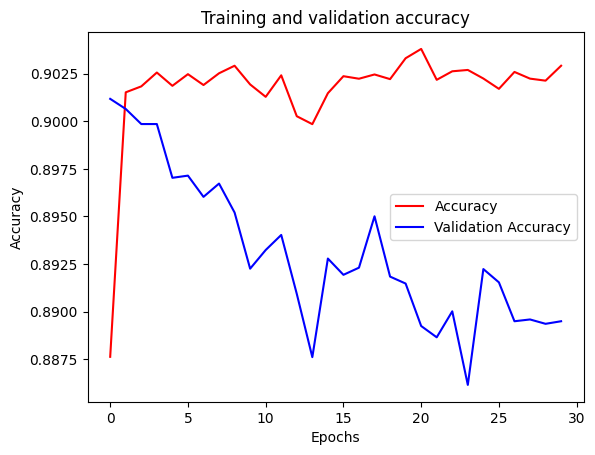

In [18]:
epochs = [*range(30)]

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])
plt.show()

In [19]:
y_pred = model.predict(X_test_padded)
y_pred = np.argmax(y_pred, axis=1)
print("Classification report:\n", classification_report(y_test, y_pred))

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 25s 8ms/step
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.78      0.81     13125
           1       0.97      0.84      0.90      9373
           2       0.92      0.91      0.91     29756
           3       0.81      0.92      0.86     19426
           4       0.92      0.93      0.92     24308

    accuracy                           0.89     95988
   macro avg       0.89      0.87      0.88     95988
weighted avg       0.89      0.89      0.89     95988



In [20]:
model.save("LSTM_emotion_model.h5")


In [21]:
model.save("LSTM_emotion_model.keras")


In [23]:
import pickle

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
